In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv('sampleSubmission.csv')
df

,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat
...,...,...
299995,299996,cat
299996,299997,cat
299997,299998,cat
299998,299999,cat


In [82]:
df.shape

(300000, 2)

In [83]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz


--2026-02-08 11:46:21--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.3’

cifar-10-python.tar 100%[===================>] 162.60M  80.2MB/s    in 2.0s    

2026-02-08 11:46:23 (80.2 MB/s) - ‘cifar-10-python.tar.gz.3’ saved [170498071/170498071]



In [84]:
test_batch = load_batch('cifar-10-batches-py/test_batch')
X_test = test_batch[b'data'].reshape(-1,3,32,32)
X_test = np.transpose(X_test, (0,2,3,1))
np.save("test.npy", X_test)

print("test.npy shape:", X_test.shape)


test.npy shape: (10000, 32, 32, 3)


In [85]:
import pickle
import numpy as np
import pandas as pd

def load_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X = []
y = []

for i in range(1, 6):
    batch = load_batch(f'cifar-10-batches-py/data_batch_{i}')
    X.append(batch[b'data'])
    y.extend(batch[b'labels'])

X = np.concatenate(X, axis=0)
X = X.reshape(-1, 3, 32, 32)
X = np.transpose(X, (0, 2, 3, 1))

labels_map = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']
labels = [labels_map[i] for i in y]

np.save("train.npy", X)
pd.DataFrame({
    "id": range(1, 50001),
    "label": labels
}).to_csv("trainLabels.csv", index=False)

print("train.npy shape:", X.shape)
print("trainLabels.csv created")


train.npy shape: (50000, 32, 32, 3)
trainLabels.csv created


In [86]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


In [87]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z) ** 2

def leaky_relu(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def leaky_relu_derivative(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))


In [88]:
class NeuralNetwork:

    def __init__(self, layer_sizes, dropout_rate=0.3, use_batch_norm=True,
                 activation='relu', initialization='kaiming', l2_lambda=0.01):

        self.layer_sizes = layer_sizes
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.activation = activation
        self.initialization = initialization
        self.l2_lambda = l2_lambda
        self.parameters = {}
        self.bn_parameters = {}
        self.initialize_parameters()

    def initialize_parameters(self):
        np.random.seed(42)

        for l in range(1, len(self.layer_sizes)):
            if self.initialization == 'xavier':

                self.parameters[f'W{l}'] = np.random.randn(
                    self.layer_sizes[l],
                    self.layer_sizes[l-1]
                ) * np.sqrt(1.0 / self.layer_sizes[l-1])

            elif self.initialization == 'kaiming':

                self.parameters[f'W{l}'] = np.random.randn(
                    self.layer_sizes[l],
                    self.layer_sizes[l-1]
                ) * np.sqrt(2.0 / self.layer_sizes[l-1])

            else:

                self.parameters[f'W{l}'] = np.random.randn(
                    self.layer_sizes[l],
                    self.layer_sizes[l-1]
                ) * 0.01

            self.parameters[f'b{l}'] = np.zeros((self.layer_sizes[l], 1))


            if self.use_batch_norm and l < len(self.layer_sizes) - 1:
                self.bn_parameters[f'gamma{l}'] = np.ones((self.layer_sizes[l], 1))
                self.bn_parameters[f'beta{l}'] = np.zeros((self.layer_sizes[l], 1))
                self.bn_parameters[f'running_mean{l}'] = np.zeros((self.layer_sizes[l], 1))
                self.bn_parameters[f'running_var{l}'] = np.ones((self.layer_sizes[l], 1))

    def apply_activation(self, Z):

        if self.activation == 'relu':
            return relu(Z)
        elif self.activation == 'tanh':
            return tanh(Z)
        elif self.activation == 'leaky_relu':
            return leaky_relu(Z)
        else:
            return relu(Z)

    def apply_activation_derivative(self, Z):
        if self.activation == 'relu':
            return relu_derivative(Z)
        elif self.activation == 'tanh':
            return tanh_derivative(Z)
        elif self.activation == 'leaky_relu':
            return leaky_relu_derivative(Z)
        else:
            return relu_derivative(Z)

    def batch_norm_forward(self, Z, layer, training=True, momentum=0.9):

        if not training:
            Z_norm = (Z - self.bn_parameters[f'running_mean{layer}']) / \
                     np.sqrt(self.bn_parameters[f'running_var{layer}'] + 1e-8)
        else:
            mean = np.mean(Z, axis=1, keepdims=True)
            var = np.var(Z, axis=1, keepdims=True)
            Z_norm = (Z - mean) / np.sqrt(var + 1e-8)

            self.bn_parameters[f'running_mean{layer}'] = \
                momentum * self.bn_parameters[f'running_mean{layer}'] + (1 - momentum) * mean
            self.bn_parameters[f'running_var{layer}'] = \
                momentum * self.bn_parameters[f'running_var{layer}'] + (1 - momentum) * var

        Z_out = self.bn_parameters[f'gamma{layer}'] * Z_norm + self.bn_parameters[f'beta{layer}']
        return Z_out, Z_norm

    def forward_propagation(self, X, training=True):

        cache = {'A0': X}
        L = len(self.layer_sizes) - 1

        for l in range(1, L):
            Z = np.dot(self.parameters[f'W{l}'], cache[f'A{l-1}']) + self.parameters[f'b{l}']
            cache[f'Z{l}'] = Z

            if self.use_batch_norm:
                Z_bn, Z_norm = self.batch_norm_forward(Z, l, training)
                cache[f'Z_norm{l}'] = Z_norm
                cache[f'Z_bn{l}'] = Z_bn
                A = self.apply_activation(Z_bn)
            else:
                A = self.apply_activation(Z)

            if training and self.dropout_rate > 0:
                D = (np.random.rand(A.shape[0], A.shape[1]) > self.dropout_rate).astype(float)
                A = A * D / (1 - self.dropout_rate)
                cache[f'D{l}'] = D

            cache[f'A{l}'] = A

        # Output layer
        Z = np.dot(self.parameters[f'W{L}'], cache[f'A{L-1}']) + self.parameters[f'b{L}']
        A = sigmoid(Z)
        cache[f'Z{L}'] = Z
        cache[f'A{L}'] = A

        return A, cache

    def compute_cost(self, AL, Y, parameters):

        m = Y.shape[1]

        # Binary cross-entropy
        cross_entropy_cost = -np.mean(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8))

        # L2 regularization
        l2_cost = 0
        L = len(self.layer_sizes) - 1
        for l in range(1, L + 1):
            l2_cost += np.sum(np.square(parameters[f'W{l}']))

        l2_cost = (self.l2_lambda / (2 * m)) * l2_cost

        total_cost = cross_entropy_cost + l2_cost
        return total_cost

    def batch_norm_backward(self, dZ_bn, Z_norm, layer, m):
        dgamma = np.sum(dZ_bn * Z_norm, axis=1, keepdims=True)
        dbeta = np.sum(dZ_bn, axis=1, keepdims=True)

        dZ_norm = dZ_bn * self.bn_parameters[f'gamma{layer}']

        var = self.bn_parameters[f'running_var{layer}']
        std = np.sqrt(var + 1e-8)

        dZ = (1.0 / m) * (1.0 / std) * (
            m * dZ_norm - np.sum(dZ_norm, axis=1, keepdims=True) -
            Z_norm * np.sum(dZ_norm * Z_norm, axis=1, keepdims=True)
        )

        return dZ, dgamma, dbeta

    def backward_propagation(self, cache, Y):

        grads = {}
        L = len(self.layer_sizes) - 1
        m = Y.shape[1]

        # Output layer
        dZ = cache[f'A{L}'] - Y
        grads[f'dW{L}'] = np.dot(dZ, cache[f'A{L-1}'].T) / m + \
                          (self.l2_lambda / m) * self.parameters[f'W{L}']
        grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(self.parameters[f'W{L}'].T, dZ)

        # Hidden layers
        for l in reversed(range(1, L)):
            if f'D{l}' in cache:
                dA_prev = dA_prev * cache[f'D{l}'] / (1 - self.dropout_rate)

            if self.use_batch_norm:
                dZ_bn = dA_prev * self.apply_activation_derivative(cache[f'Z_bn{l}'])
                dZ, dgamma, dbeta = self.batch_norm_backward(dZ_bn, cache[f'Z_norm{l}'], l, m)
                grads[f'dgamma{l}'] = dgamma
                grads[f'dbeta{l}'] = dbeta
            else:
                dZ = dA_prev * self.apply_activation_derivative(cache[f'Z{l}'])

            grads[f'dW{l}'] = np.dot(dZ, cache[f'A{l-1}'].T) / m + \
                             (self.l2_lambda / m) * self.parameters[f'W{l}']
            grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m

            if l > 1:
                dA_prev = np.dot(self.parameters[f'W{l}'].T, dZ)

        return grads



In [89]:

class SGDOptimizer:

    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}
        self.name = "SGD"

    def update(self, parameters, bn_parameters, grads, use_batch_norm):
        if not self.velocity:
            for key in parameters:
                self.velocity[key] = np.zeros_like(parameters[key])
            if use_batch_norm:
                for key in bn_parameters:
                    if 'gamma' in key or 'beta' in key:
                        self.velocity[key] = np.zeros_like(bn_parameters[key])

        for key in parameters:
            if f'd{key}' in grads:
                self.velocity[key] = (self.momentum * self.velocity[key] -
                                     self.learning_rate * grads[f'd{key}'])
                parameters[key] += self.velocity[key]

        if use_batch_norm:
            for key in bn_parameters:
                if ('gamma' in key or 'beta' in key) and f'd{key}' in grads:
                    self.velocity[key] = (self.momentum * self.velocity[key] -
                                         self.learning_rate * grads[f'd{key}'])
                    bn_parameters[key] += self.velocity[key]

        return parameters, bn_parameters



In [90]:
class AdamOptimizer:

    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
        self.name = "Adam"

    def update(self, parameters, bn_parameters, grads, use_batch_norm):
        if not self.m:
            for key in parameters:
                self.m[key] = np.zeros_like(parameters[key])
                self.v[key] = np.zeros_like(parameters[key])
            if use_batch_norm:
                for key in bn_parameters:
                    if 'gamma' in key or 'beta' in key:
                        self.m[key] = np.zeros_like(bn_parameters[key])
                        self.v[key] = np.zeros_like(bn_parameters[key])

        self.t += 1

        for key in parameters:
            if f'd{key}' in grads:
                self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[f'd{key}']
                self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[f'd{key}'] ** 2)

                m_corrected = self.m[key] / (1 - self.beta1 ** self.t)
                v_corrected = self.v[key] / (1 - self.beta2 ** self.t)

                parameters[key] -= self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.epsilon)

        if use_batch_norm:
            for key in bn_parameters:
                if ('gamma' in key or 'beta' in key) and f'd{key}' in grads:
                    self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[f'd{key}']
                    self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[f'd{key}'] ** 2)

                    m_corrected = self.m[key] / (1 - self.beta1 ** self.t)
                    v_corrected = self.v[key] / (1 - self.beta2 ** self.t)

                    bn_parameters[key] -= self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.epsilon)

        return parameters, bn_parameters


In [91]:
class RMSpropOptimizer:

    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.s = {}
        self.name = "RMSprop"

    def update(self, parameters, bn_parameters, grads, use_batch_norm):
        if not self.s:
            for key in parameters:
                self.s[key] = np.zeros_like(parameters[key])
            if use_batch_norm:
                for key in bn_parameters:
                    if 'gamma' in key or 'beta' in key:
                        self.s[key] = np.zeros_like(bn_parameters[key])

        for key in parameters:
            if f'd{key}' in grads:
                self.s[key] = (self.decay_rate * self.s[key] +
                              (1 - self.decay_rate) * (grads[f'd{key}'] ** 2))
                parameters[key] -= (self.learning_rate * grads[f'd{key}'] /
                                   (np.sqrt(self.s[key]) + self.epsilon))

        if use_batch_norm:
            for key in bn_parameters:
                if ('gamma' in key or 'beta' in key) and f'd{key}' in grads:
                    self.s[key] = (self.decay_rate * self.s[key] +
                                  (1 - self.decay_rate) * (grads[f'd{key}'] ** 2))
                    bn_parameters[key] -= (self.learning_rate * grads[f'd{key}'] /
                                          (np.sqrt(self.s[key]) + self.epsilon))

        return parameters, bn_parameters



In [92]:
def load_custom_cifar10_data():

    global used_sample_data
    used_sample_data = False

    required_files = ['train.npy', 'test.npy', 'trainLabels.csv']
    missing_files = [f for f in required_files if not os.path.exists(f)]

    if missing_files:
        print(f"\n Missing files: {missing_files}")
        print("Using sample data instead...")
        used_sample_data = True
        return load_sample_data()

    print("\nAll required files found")

    X_train_full = np.load('train.npy')
    X_test_full = np.load('test.npy')
    train_labels_df = pd.read_csv('trainLabels.csv')

    print(f"\nTrain shape: {X_train_full.shape}")
    print(f"Test shape: {X_test_full.shape}")
    print(f"Labels shape: {train_labels_df.shape}")

    if 'label' in train_labels_df.columns:
        y_train_full = train_labels_df['label'].values
    elif 'Label' in train_labels_df.columns:
        y_train_full = train_labels_df['Label'].values
    else:
        y_train_full = train_labels_df.iloc[:, 1].values

    print(f"Unique labels: {np.unique(y_train_full)}")

    if X_train_full.shape[0] != len(y_train_full):
        print(f"\nShape mismatch. Using sample data.")
        used_sample_data = True
        return load_sample_data()


    if isinstance(y_train_full[0], str):
        cat_dog_mask = np.isin(y_train_full, ['cat', 'dog'])
        X_train = X_train_full[cat_dog_mask]
        y_train = y_train_full[cat_dog_mask]
        y_train = (y_train == 'dog').astype(int)
    else:
        cat_dog_mask = np.isin(y_train_full, [3, 5])
        X_train = X_train_full[cat_dog_mask]
        y_train = y_train_full[cat_dog_mask]
        y_train = (y_train == 5).astype(int)

    print(f"\nFiltered training samples: {len(X_train)}")
    print(f"Cats: {np.sum(y_train==0)}, Dogs: {np.sum(y_train==1)}")

    return X_train, y_train, X_test_full

def load_sample_data():

    print("\nCreating sample data...")
    np.random.seed(42)

    X_train = np.random.randint(0, 256, (8000, 32, 32, 3), dtype=np.uint8)
    y_train = np.random.randint(0, 2, 8000)
    X_test = np.random.randint(0, 256, (2000, 32, 32, 3), dtype=np.uint8)

    return X_train, y_train, X_test


In [93]:
def create_mini_batches(X, Y, batch_size):

    m = X.shape[1]
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_complete_batches = m // batch_size

    for k in range(num_complete_batches):
        mini_batch_X = shuffled_X[:, k * batch_size:(k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size:(k + 1) * batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_batches * batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_batches * batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    return mini_batches




In [94]:
def train_model_with_early_stopping(model, optimizer, X_train, y_train, X_val, y_val,
                                    epochs=100, batch_size=64, patience=15):

    print(f"\nTraining with {optimizer.name} optimizer")
    print(f"Activation: {model.activation}, Init: {model.initialization}")
    print(f"Epochs: {epochs}, Batch size: {batch_size}, Patience: {patience}")


    history = {
        'train_cost': [],
        'val_cost': [],
        'train_acc': [],
        'val_acc': []
    }

    best_val_cost = float('inf')
    patience_counter = 0
    best_parameters = None
    best_bn_parameters = None

    for epoch in range(epochs):
        epoch_cost = 0
        mini_batches = create_mini_batches(X_train, y_train, batch_size)

        for mini_batch_X, mini_batch_Y in mini_batches:
            AL, cache = model.forward_propagation(mini_batch_X, training=True)
            cost = model.compute_cost(AL, mini_batch_Y, model.parameters)
            epoch_cost += cost

            grads = model.backward_propagation(cache, mini_batch_Y)
            model.parameters, model.bn_parameters = optimizer.update(
                model.parameters, model.bn_parameters, grads, model.use_batch_norm
            )

        epoch_cost /= len(mini_batches)
        history['train_cost'].append(epoch_cost)

        # Validation
        AL_val, _ = model.forward_propagation(X_val, training=False)
        val_cost = model.compute_cost(AL_val, y_val, model.parameters)
        history['val_cost'].append(val_cost)

        # Accuracy
        train_pred = (model.forward_propagation(X_train, training=False)[0] > 0.5).astype(int)
        train_acc = np.mean(train_pred == y_train)
        history['train_acc'].append(train_acc)

        val_pred = (AL_val > 0.5).astype(int)
        val_acc = np.mean(val_pred == y_val)
        history['val_acc'].append(val_acc)

        # Early stopping check
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            patience_counter = 0

            best_parameters = {k: v.copy() for k, v in model.parameters.items()}
            best_bn_parameters = {k: v.copy() for k, v in model.bn_parameters.items()}
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {epoch_cost:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_cost:.4f}, Acc: {val_acc:.4f} | "
                  f"Patience: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation cost: {best_val_cost:.4f}")

            model.parameters = best_parameters
            model.bn_parameters = best_bn_parameters
            break

    return history


In [95]:
def evaluate_model(model, X_test, y_test):

    AL, _ = model.forward_propagation(X_test, training=False)
    y_pred = (AL > 0.5).astype(int).flatten()
    y_true = y_test.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred
    }


In [96]:
def predict_test_set(model, X_test):

    AL, _ = model.forward_propagation(X_test, training=False)
    y_pred = (AL > 0.5).astype(int).flatten()
    return y_pred

In [97]:

def plot_comprehensive_results(all_results):

    fig = plt.figure(figsize=(24, 20))


    configs = list(all_results.keys())


    for idx, config in enumerate(configs[:4]):
        history = all_results[config]['history']


        ax = plt.subplot(5, 4, idx*2 + 1)
        ax.plot(history['train_cost'], label='Train', alpha=0.7)
        ax.plot(history['val_cost'], label='Val', alpha=0.7)
        ax.set_title(f'{config}\nLoss', fontsize=10, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)


        ax = plt.subplot(5, 4, idx*2 + 2)
        ax.plot(history['train_acc'], label='Train', alpha=0.7)
        ax.plot(history['val_acc'], label='Val', alpha=0.7)
        ax.set_title(f'{config}\nAccuracy', fontsize=10, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(True, alpha=0.3)


    ax9 = plt.subplot(5, 4, 9)
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    x = np.arange(len(configs))
    width = 0.2

    for i, metric in enumerate(metrics):
        values = [all_results[cfg]['metrics'][metric] for cfg in configs]
        ax9.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

    ax9.set_xlabel('Configuration')
    ax9.set_ylabel('Score')
    ax9.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
    ax9.set_xticks(x + width * 1.5)
    ax9.set_xticklabels([cfg.split('_')[0][:15] for cfg in configs], rotation=45, ha='right')
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')
    ax9.set_ylim([0, 1.1])

    # Confusion matrices
    for idx, config in enumerate(configs[:9]):
        ax = plt.subplot(5, 4, 10 + idx)
        cm = all_results[config]['metrics']['confusion_matrix']

        im = ax.imshow(cm, cmap='Blues')
        ax.set_title(f'{config.split("_")[0][:15]}', fontsize=9, fontweight='bold')
        ax.set_xlabel('Pred')
        ax.set_ylabel('True')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Cat', 'Dog'])
        ax.set_yticklabels(['Cat', 'Dog'])

        for i in range(2):
            for j in range(2):
                ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                       color='white' if cm[i, j] > cm.max()/2 else 'black',
                       fontsize=12, fontweight='bold')

    plt.suptitle('CIFAR-10 Dog vs Cat - Comprehensive Results\nActivations, Initializations, Optimizers Comparison',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
    print("\nSaved: comprehensive_comparison.png")

In [100]:
def main():
    print("CIFAR-10 DOG VS CAT")

    # Load data
    X_train, y_train, X_test = load_custom_cifar10_data()

    # Normalize
    print("\nPreprocessing...")
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    if len(X_train.shape) == 4:
        n_train = X_train.shape[0]
        n_test = X_test.shape[0]
        X_train = X_train.reshape(n_train, -1)
        X_test = X_test.reshape(n_test, -1)


    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Training: {X_train_split.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples")
    print(f"Test: {X_test.shape[0]} samples")


    X_train_split = X_train_split.T
    y_train_split = y_train_split.reshape(1, -1)
    X_val = X_val.T
    y_val = y_val.reshape(1, -1)
    X_test_T = X_test.T

    # Network architecture
    input_size = X_train_split.shape[0]
    layer_sizes = [input_size, 256, 128, 64, 1]

    print(f"\nArchitecture: {layer_sizes}")


    activations = ['relu', 'tanh', 'leaky_relu']
    initializations = ['xavier', 'kaiming', 'random']
    optimizers_configs = [
        ('SGD', SGDOptimizer(learning_rate=0.01, momentum=0.9)),
        ('Adam', AdamOptimizer(learning_rate=0.001)),
        ('RMSprop', RMSpropOptimizer(learning_rate=0.001))
    ]

    print("\nRunning Experiment")
    print(f"\nTotal experiments: {len(activations) * len(initializations) * len(optimizers_configs)}")


    all_results = {}
    experiment_num = 0


    for activation in activations:
        for initialization in initializations:
            for opt_name, optimizer in optimizers_configs:
                experiment_num += 1
                config_name = f"{activation}_{initialization}_{opt_name}"


                print(f"\nCombinationNO {experiment_num}: {config_name}")



                model = NeuralNetwork(
                    layer_sizes,
                    dropout_rate=0.3,
                    use_batch_norm=True,
                    activation=activation,
                    initialization=initialization,
                    l2_lambda=0.01
                )

                # Train with early stopping
                history = train_model_with_early_stopping(
                    model, optimizer,
                    X_train_split, y_train_split,
                    X_val, y_val,
                    epochs=100,
                    batch_size=64,
                    patience=15
                )


                metrics = evaluate_model(model, X_val, y_val)

                print(f"\nValidation Results:")
                print(f"  Accuracy:  {metrics['accuracy']:.4f}")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall:    {metrics['recall']:.4f}")
                print(f"  F1-Score:  {metrics['f1_score']:.4f}")

                all_results[config_name] = {
                    'history': history,
                    'metrics': metrics,
                    'model': model
                }

    # Find best configuration

    print("Result Summary")

    print(f"{'Configuration':<30} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
    print("-"*80)

    for config_name in all_results:
        metrics = all_results[config_name]['metrics']
        print(f"{config_name:<30} "
              f"{metrics['accuracy']:<8.4f} "
              f"{metrics['precision']:<8.4f} "
              f"{metrics['recall']:<8.4f} "
              f"{metrics['f1_score']:<8.4f}")



    best_config = max(all_results.items(), key=lambda x: x[1]['metrics']['f1_score'])
    best_config_name = best_config[0]
    best_metrics = best_config[1]['metrics']
    best_model = best_config[1]['model']

    print(f"\nBest Configuration: {best_config_name}")
    print(f"   Accuracy:  {best_metrics['accuracy']:.4f} ({best_metrics['accuracy']*100:.2f}%)")
    print(f"   Precision: {best_metrics['precision']:.4f}")
    print(f"   Recall:    {best_metrics['recall']:.4f}")
    print(f"   F1-Score:  {best_metrics['f1_score']:.4f}")


    print("Generating Visualization")
    plot_comprehensive_results(all_results)

    # Make predictions on test set
    print("Making Prediction Set")
    test_predictions = predict_test_set(best_model, X_test_T)


    submission_df = pd.DataFrame({
        'id': range(1, len(test_predictions) + 1),
        'label': test_predictions
    })

    submission_df.to_csv('best_submission.csv', index=False)
    print(f"\nSaved predictions: best_submission.csv")
    print(f"  Total predictions: {len(test_predictions)}")
    print(f"  Predicted cats: {np.sum(test_predictions==0)}")
    print(f"  Predicted dogs: {np.sum(test_predictions==1)}")

    print("All Experiment Completed!")

    print(f"  Activation: {best_config_name.split('_')[0]}")
    print(f"  Initialization: {best_config_name.split('_')[1]}")
    print(f"  Optimizer: {best_config_name.split('_')[2]}")


CIFAR-10 DOG VS CAT

All required files found

Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)
Labels shape: (50000, 2)
Unique labels: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']

Filtered training samples: 10000
Cats: 5000, Dogs: 5000

Preprocessing...
Training: 8000 samples
Validation: 2000 samples
Test: 10000 samples

Architecture: [3072, 256, 128, 64, 1]

Running Experiment

Total experiments: 27

CombinationNO 1: relu_xavier_SGD

Training with SGD optimizer
Activation: relu, Init: xavier
Epochs: 100, Batch size: 64, Patience: 15
Epoch   1/100 | Train Loss: 0.7200, Acc: 0.6224 | Val Loss: 0.6611, Acc: 0.5890 | Patience: 0/15
Epoch  10/100 | Train Loss: 0.6306, Acc: 0.7419 | Val Loss: 0.6629, Acc: 0.6175 | Patience: 5/15
Epoch  20/100 | Train Loss: 0.5372, Acc: 0.8395 | Val Loss: 0.6766, Acc: 0.6455 | Patience: 15/15

⚠ Early stopping triggered at epoch 20
Best validation cost: 0.6501

Validation Results:
  Accuracy:  0.6160
  Pr

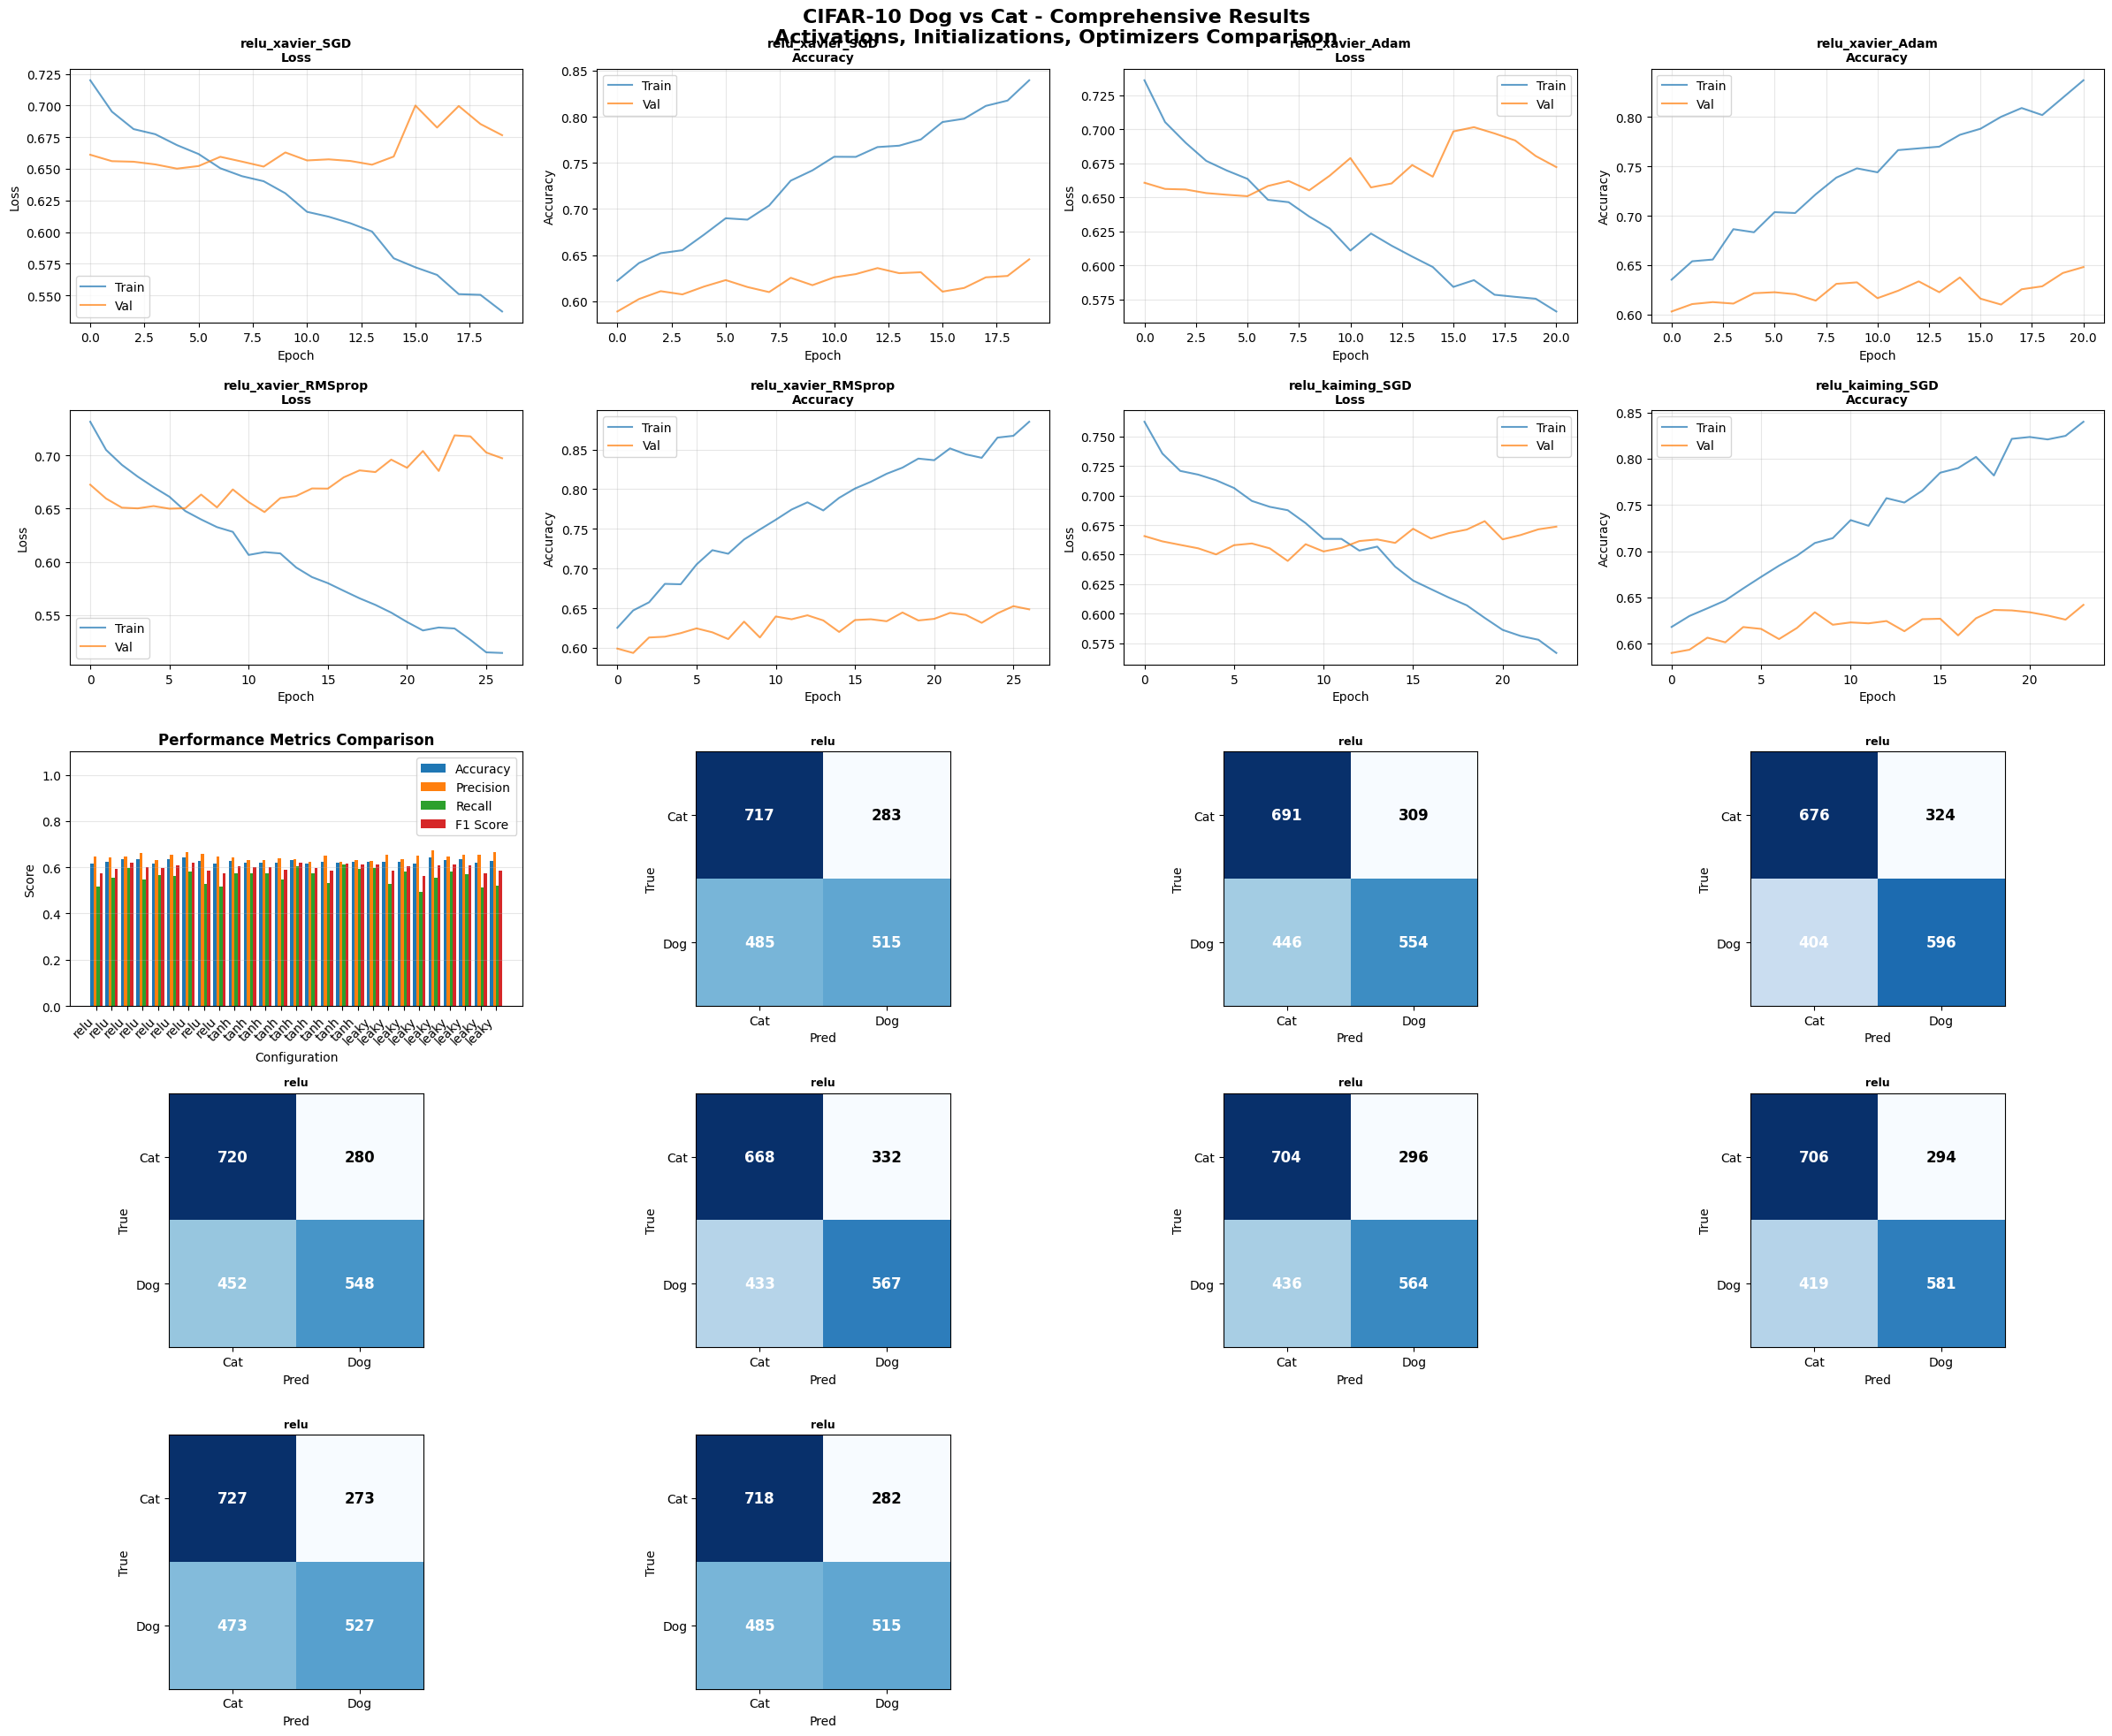

In [101]:
if __name__ == "__main__":
    main()
